Many thanks to the following kagglers and their great kernels:

@Andrew Lukyanenko, https://www.kaggle.com/artgor/toxicity-eda-model-interpretation-and-more

@Eike Dehling: https://www.kaggle.com/eikedehling/feature-engineering

@Jagan: https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

@Theo Viel: https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

@Aditya Soni: https://www.kaggle.com/adityaecdrid/public-version-text-cleaning-vocab-65

@Guillaume Martin: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

@Shujian Liu: https://www.kaggle.com/shujian/test-the-difficulty-of-this-classification-tasks

Thanks @kotakota1110 for his suggestion in Time Series part.


**Content**

* Text Features heatmap

* Weighted toxic comments & different identities

* Identities & Comment Labels.

* Time Series Toxicity with Race, Religion, Sexual orientation, Gender and Disability (updated April 18, weighted the data again)

* What happened in Jan 2017? (updated April 14)

* Which Time are People More Toxic? (updated April 16)

* Words Frequented and Toxic_Mask

* Text Processing (updated April 21)

* Memory Reducing (updated April 22)

* Test the Difficulty of the Task (updated April 24)

-----To be added

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
sub = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')

In [2]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
train.isnull().sum(), test.isnull().sum()

(id                                           0
 target                                       0
 comment_text                                 0
 severe_toxicity                              0
 obscene                                      0
 identity_attack                              0
 insult                                       0
 threat                                       0
 asian                                  1399744
 atheist                                1399744
 bisexual                               1399744
 black                                  1399744
 buddhist                               1399744
 christian                              1399744
 female                                 1399744
 heterosexual                           1399744
 hindu                                  1399744
 homosexual_gay_or_lesbian              1399744
 intellectual_or_learning_disability    1399744
 jewish                                 1399744
 latino                                 

FE: Some features might have relations with Toxicity, like capitals letters in the text, punctuations in the texts. Add the new features into the training set.

In [4]:
train['total_length'] = train['comment_text'].apply(len)
train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
train['num_punctuation'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train['num_symbols'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
train['num_unique_words'] = train['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
train['words_vs_unique'] = train['num_unique_words'] / train['num_words']
train['num_smilies'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [5]:
features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols')
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit','identity_annotator_count', 'toxicity_annotator_count')
rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

Let's see the correlations between new features and targets.

In [6]:
train_correlations

,disagree,funny,identity_annotator_count,identity_attack,insult,likes,obscene,sad,severe_toxicity,sexual_explicit,target,threat,toxicity_annotator_count,wow
total_length,0.017617,-0.084710,0.020840,0.053430,0.009085,0.060639,0.009823,-0.019940,0.007962,0.019882,0.006444,-0.013198,-0.030894,0.002572
capitals,0.003928,-0.039221,0.012405,0.050489,0.026358,0.018707,0.027995,-0.005448,0.025127,0.014144,0.026120,0.000721,-0.009082,0.009687
caps_vs_length,-0.021716,0.021263,-0.005510,-0.008477,-0.006029,-0.038470,0.017088,0.002848,0.010594,-0.003575,-0.005344,0.000822,0.015381,-0.000603
num_exclamation_marks,-0.009384,0.007073,0.000869,0.017085,0.052533,-0.007866,0.056108,0.005158,0.035388,0.019437,0.055152,0.021267,0.024115,0.002225
num_question_marks,-0.002180,-0.009290,0.006305,0.028554,0.014366,-0.002731,0.019233,0.002023,0.011662,0.015987,0.019308,-0.000430,-0.003307,0.001263
num_punctuation,0.001415,-0.057187,0.018050,0.042990,0.018911,0.029581,0.017701,-0.016511,0.013266,0.018985,0.016974,-0.006479,-0.021231,0.001959
num_words,0.016121,-0.084398,0.020595,0.050527,0.011975,0.059481,0.014536,-0.019412,0.009696,0.021525,0.009579,-0.009893,-0.029856,0.002714
num_unique_words,0.019634,-0.085764,0.020787,0.053659,0.019494,0.063874,0.017918,-0.018110,0.011900,0.022816,0.016702,-0.008946,-0.029814,0.003490
words_vs_unique,-0.020712,0.079045,-0.019749,-0.048941,0.001135,-0.060162,-0.003007,0.016223,-0.005329,-0.015748,0.001172,0.009367,0.027853,-0.004150
num_smilies,-0.010936,0.010109,-0.000576,-0.008337,-0.009401,-0.016607,-0.001024,-0.002133,-0.003877,-0.000414,-0.010040,-0.003190,-0.003030,-0.002777


Correlations between new features and targets in heatmap:

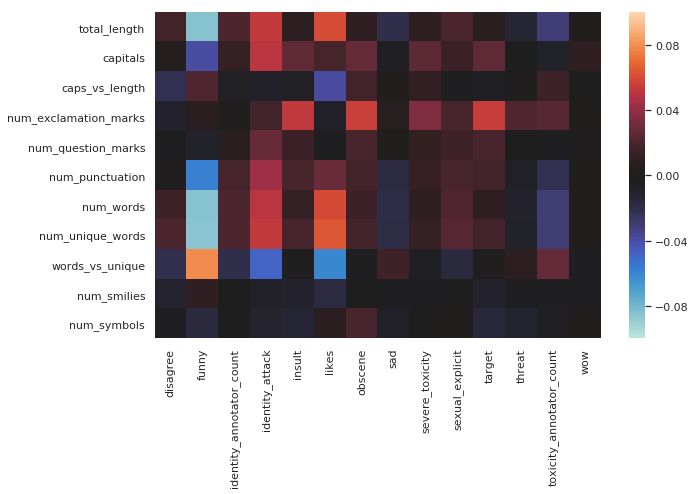

In [7]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)

Percent of toxic comments related to different identities, using target and popolation amount of each identity as weights:

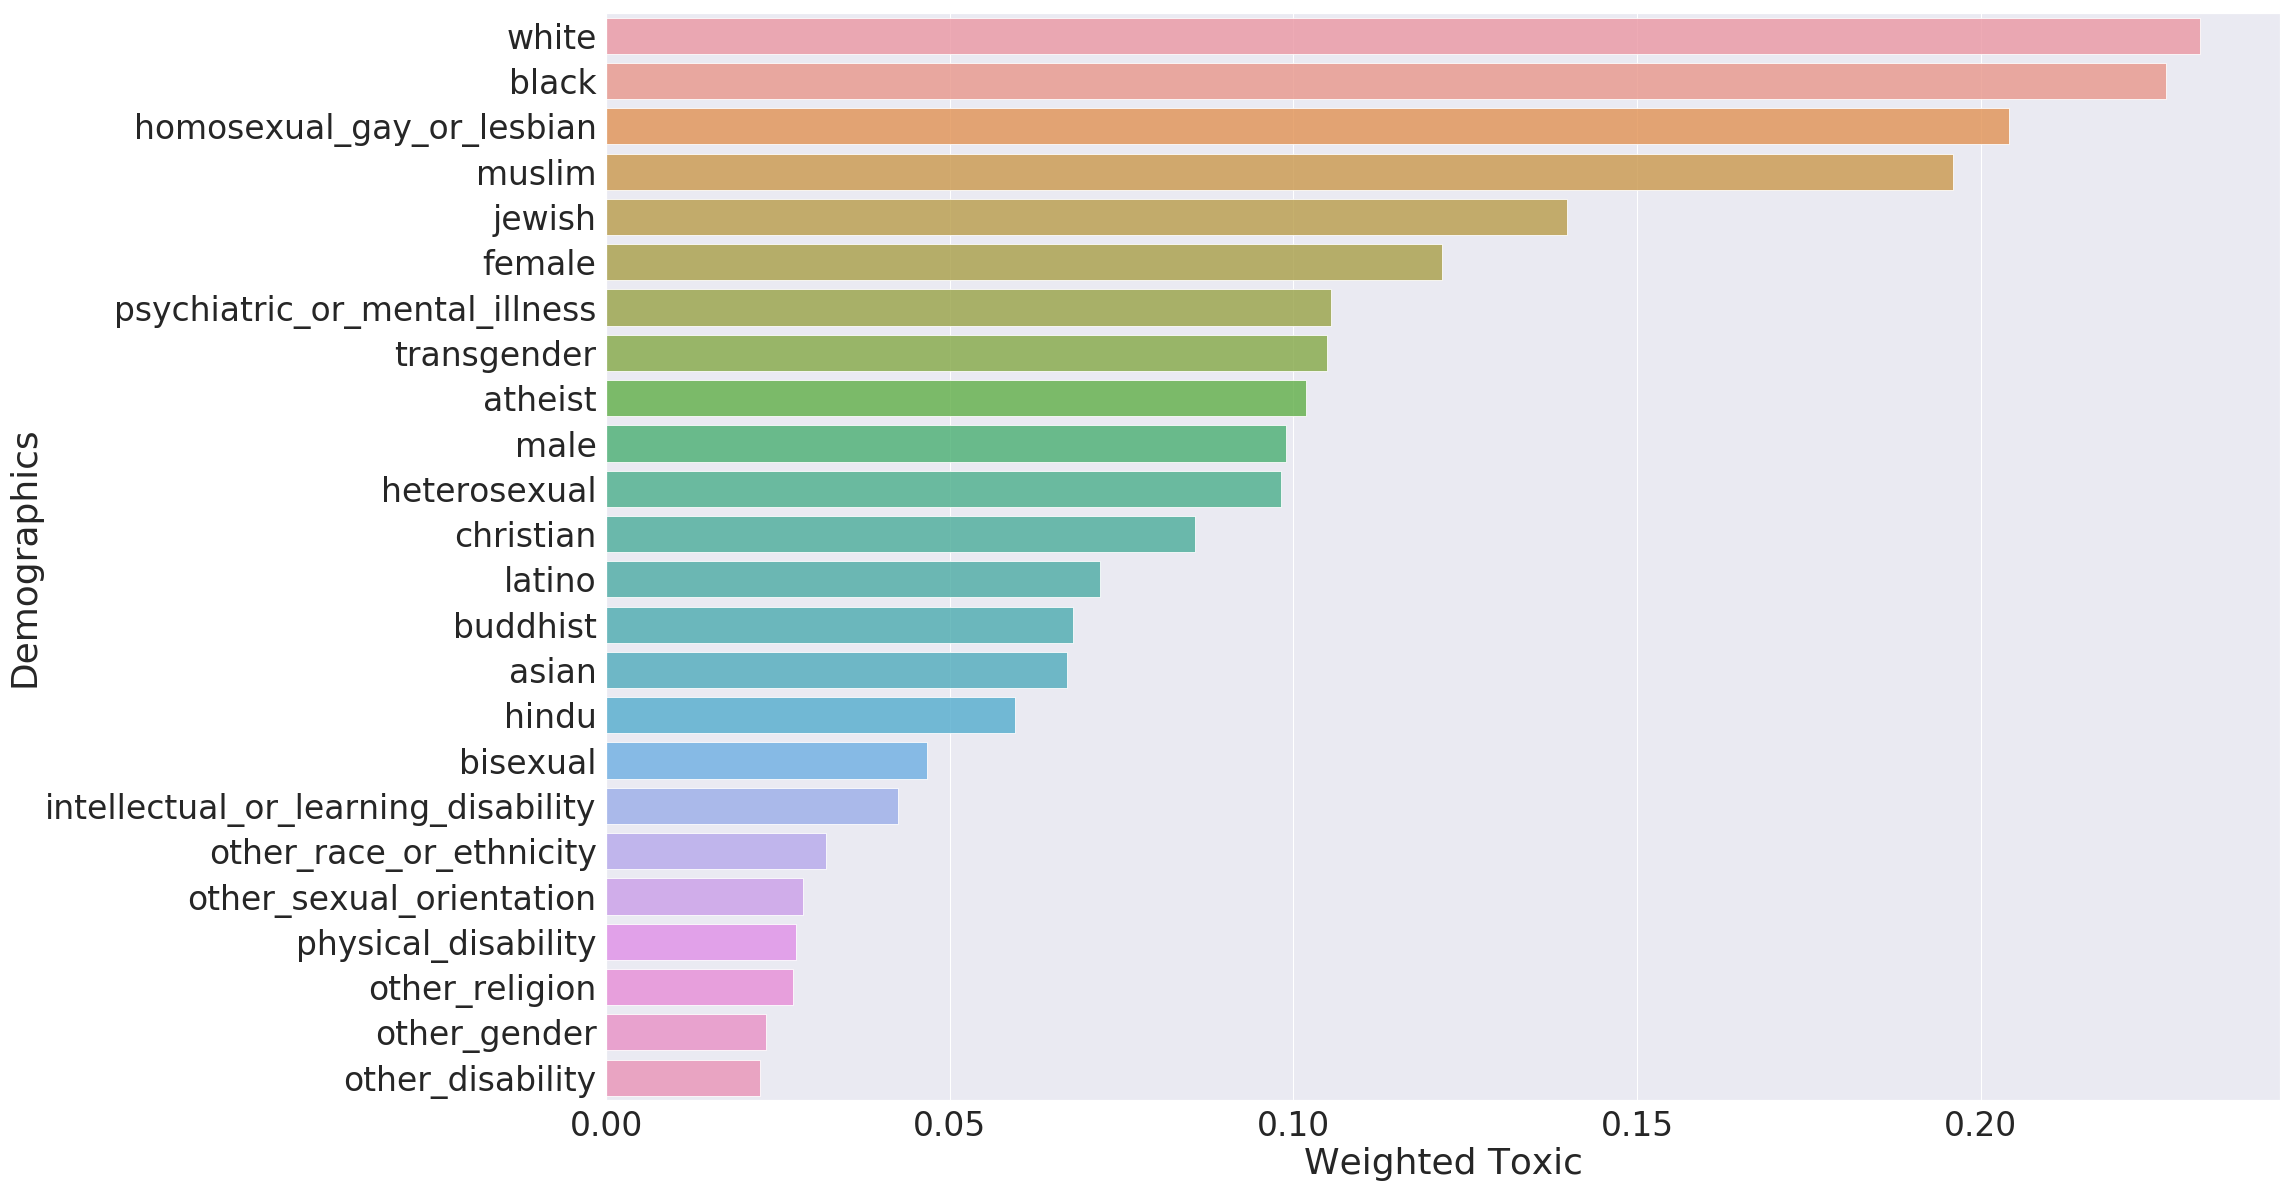

In [8]:
demographics = train.loc[:, ['target']+list(train)[slice(8,32)]].dropna()
weighted_toxic = demographics.iloc[:, 1:].multiply(demographics.iloc[:, 0], axis="index").sum()/demographics.iloc[:, 1:][demographics.iloc[:, 1:]>0].count()
weighted_toxic = weighted_toxic.sort_values(ascending=False)
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values, y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxic')
plt.show()

Meanwhile, we can check the correlations between identities and the comment labels.

In [9]:
identities = tuple(train.iloc[:, 8:32])
rows = [{c:train[f].corr(train[c]) for c in columns} for f in identities]
poptoxicity_correlations = pd.DataFrame(rows, index=identities)

In [10]:
poptoxicity_correlations

,disagree,funny,identity_annotator_count,identity_attack,insult,likes,obscene,sad,severe_toxicity,sexual_explicit,target,threat,toxicity_annotator_count,wow
asian,0.007868,-0.000409,0.021327,0.041203,-0.000664,-0.003144,-0.004047,0.001051,0.005371,-0.013710,0.007205,-0.002817,0.001216,0.010691
atheist,0.001031,-0.002847,0.023635,0.031167,0.005152,-0.002436,-0.000122,0.000051,0.005047,-0.004954,0.010625,0.000781,-0.000433,-0.002600
bisexual,-0.004104,-0.003230,0.015360,0.047476,0.006283,0.009078,0.005323,-0.002987,0.009279,0.024218,0.021057,-0.001796,-0.000380,-0.000367
black,-0.000631,-0.020852,0.018075,0.314422,0.098186,-0.012769,0.026267,0.004480,0.094418,-0.006407,0.167224,0.048630,0.035702,0.001483
buddhist,-0.001719,-0.002802,0.010600,0.024143,-0.002909,-0.000621,-0.001751,-0.001348,0.004260,-0.004397,0.004613,0.002542,-0.002119,-0.001222
christian,-0.020644,-0.008460,0.018038,0.093885,-0.030669,0.021608,-0.025650,-0.015212,-0.000874,0.008710,-0.006776,-0.014324,-0.015846,-0.013146
female,0.008464,-0.012743,0.009830,0.052299,0.037995,0.036137,0.036250,0.005052,0.032653,0.153735,0.062904,0.023384,0.007588,0.008052
heterosexual,-0.002821,-0.002225,0.010674,0.073282,0.012613,0.006148,0.008396,-0.001339,0.018239,0.066624,0.038193,-0.003600,0.003018,-0.001381
hindu,0.002689,-0.002369,0.014825,0.022695,-0.001895,0.002924,-0.002221,-0.001025,0.003839,-0.005251,0.003607,0.001549,-0.001248,-0.000161
homosexual_gay_or_lesbian,-0.002378,-0.003616,0.020577,0.249880,0.061920,0.012015,0.026097,0.003452,0.064122,0.099424,0.131110,0.016785,0.019139,-0.001935


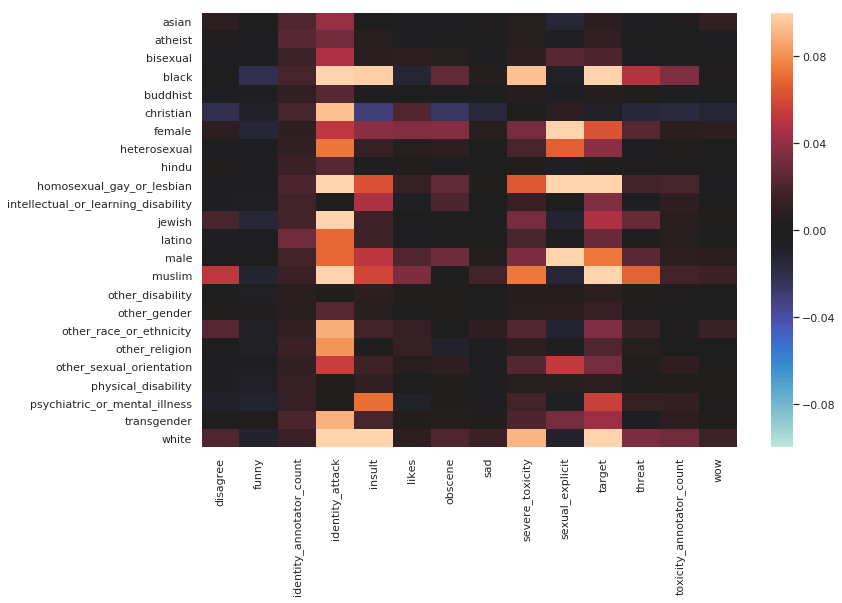

In [11]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
ax = sns.heatmap(poptoxicity_correlations, vmin=-0.1, vmax=0.1, center=0.0)

We can also check the Time Series for Toxicity with different identities:

(Thanks again for @kotakota1110's suggestion. Now we are using "target" and "identity data amount" to weight the data twice, which make more sense.)

In [12]:
withdate = train.loc[:, ['created_date', 'target']+list(train)[slice(8,32)]].dropna()
raceweighted = withdate.iloc[:, 2:]/withdate.iloc[:, 2:].sum()
race_target_weighted = raceweighted.multiply(withdate.iloc[:, 1], axis="index")
race_target_weighted['created_date'] = pd.to_datetime(withdate['created_date']).values.astype('datetime64[M]')
weighted_demo = race_target_weighted.groupby(['created_date']).sum().sort_index()

In [13]:
import plotly
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='13217', api_key='FG6itEaCMouvPJVR7DlI')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [14]:
weighted_demo[['white', 'asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity']].iplot(title = 'Time Series Toxicity & Race', filename='Time Series Toxicity & Race' )

# Click on the legend to change display. Double click for single identity.

In [15]:
weighted_demo[['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion']].iplot(title = 'Time Series Toxicity & Religion', filename='Time Series Toxicity & Religion')

# Click on the legend to change display. Double click for single identity.

In [16]:
weighted_demo[['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']].iplot(title = 'Time Series Toxicity & Sexual Orientation', filename='Time Series Toxicity & Sexual Orientation')

# Click on the legend to change display. Double click for single identity.

In [17]:
weighted_demo[['male', 'female', 'transgender', 'other_gender']].iplot(title = 'Time Series Toxicity & Gender', filename='Time Series Toxicity & Gender')

# Click on the legend to change display. Double click for single identity.

In [18]:
weighted_demo[['physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']].iplot(title = 'Time Series Toxicity & Disability', filename='Time Series Toxicity & Disability')

# Click on the legend to change display. Double click for single identity.

When plotting these charts, I found that most data have a peak around Jan 2017. A bit curious. Let's check what's different between Jan 2017 and other time.

In [19]:
alldate_toxicity = train[train['target'] >= 0.5].loc[:, ['created_date', 'target', 'comment_text']].dropna()
alldate_toxicity['created_date'] = pd.to_datetime(alldate_toxicity['created_date']).values.astype('datetime64[M]')
jan_2017_toxicity = alldate_toxicity[alldate_toxicity['created_date'] == '2017-01-01']

from nltk.corpus import stopwords
def check_frequency(data = alldate_toxicity['comment_text'], n = 20):
    stop = stopwords.words('english')
    data  = data.apply(lambda x: " ".join(x.lower() for x in x.split()))
    data = data.str.replace('[^\w\s]','')
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    freq = pd.Series(' '.join(data).split()).value_counts()[:n]
    return freq

top_10_toxicity_othertime = check_frequency(data = alldate_toxicity[alldate_toxicity['created_date'] != '2017-01-01']['comment_text'], n = 10)
top_10_toxicity_jan_2017 = check_frequency(data = jan_2017_toxicity['comment_text'], n = 10)

Which toxicity related word appears Top 10 in jan_2017, but not in other time Top 10?

In [20]:
top_10_toxicity_jan_2017.index.difference(top_10_toxicity_othertime.index)

Index([], dtype='object')

None of them... All the same... Then let's theck their frequency

In [21]:
percent_toxicity_othertime = top_10_toxicity_othertime/alldate_toxicity[alldate_toxicity['created_date'] != '2017-01-01']['comment_text'].str.split().str.len().sum()
percent_toxicity_jan_2017 = top_10_toxicity_jan_2017/jan_2017_toxicity['comment_text'].str.split().str.len().sum()
top_toxicity = pd.concat([percent_toxicity_jan_2017, percent_toxicity_othertime], axis=1, sort=False)
top_toxicity.columns = ['Jan_2017', 'Other_Time']
top_toxicity['Difference'] = top_toxicity['Jan_2017'] - top_toxicity['Other_Time']

In [22]:
top_toxicity.head(30)

,Jan_2017,Other_Time,Difference
trump,0.005175,0.004231,0.000943
people,0.003828,0.004018,-0.000191
like,0.003643,0.003650,-0.000007
dont,0.002613,0.002662,-0.000049
one,0.002587,0.002684,-0.000097
would,0.002556,0.002828,-0.000271
us,0.002512,0.001903,0.000609
get,0.002296,0.002427,-0.000131
stupid,0.001985,0.002072,-0.000087
think,0.001680,0.001696,-0.000017


In [23]:
import plotly.graph_objs as go
trace1 = go.Bar(
    x=top_toxicity.index,
    y=top_toxicity['Jan_2017'],
    name='Jan_2017'
)
trace2 = go.Bar(
    x=top_toxicity.index,
    y=top_toxicity['Other_Time'],
    name='Other_Time'
)

data = [trace2, trace1]
layout = go.Layout(
    barmode='group'
)
layout = go.Layout(yaxis=dict(tickformat=".2%"))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, title = 'Top Toxicity Comarision', filename='top_toxicity_comarision')

After checking the whole time series, I'm also curious about, Which Time are People More Toxic?

In [24]:
train['datetime64'] = pd.to_datetime(train['created_date']).values.astype('datetime64[h]')
train['hour'] = train['datetime64'].dt.hour
all_comments_by_hour = train['target'].groupby(train['hour']).sum().sort_index()/train['target'].groupby(train['hour']).sum().sum()
toxic_comments_by_hour = train[train['target'] >= 0.5]['target'].groupby(train['hour']).sum().sort_index()/train[train['target'] >= 0.5]['target'].groupby(train['hour']).sum().sum()
comments_hour_check = pd.concat([all_comments_by_hour, toxic_comments_by_hour], axis=1, sort=False)
comments_hour_check.columns = ['all_comments', 'toxic_comments']

In [25]:
labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Midnight']
tickvals = ['0', '6', '12', '18', comments_hour_check.index.max()]

trace1 = go.Scatter(
    x=comments_hour_check.index,
    y=comments_hour_check['all_comments'],
    name = 'comment percent per H',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 1)
)
trace2 = go.Scatter(
    x=comments_hour_check.index,
    y=comments_hour_check['toxic_comments'],
    name = 'toxic comment percent per H',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 1,)
)

trace3 = go.Bar(
    x=comments_hour_check.index,
    y=comments_hour_check['toxic_comments']-comments_hour_check['all_comments'],
    name = 'More Toxic Comment Ratio'
)

data = [trace1, trace2, trace3]

layout = go.Layout(yaxis=dict(tickformat=".2%"),
                   title = 'Which Time are People More Toxic',
                   xaxis=go.layout.XAxis(
                       ticktext=labels, 
                       tickvals=tickvals
                   ),
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='Which Time are People More Toxic')

Moreover, we can do something fun, digging into the text with WordCloud. Let's check the Words frequented in Toxic Comments.

In [26]:
def toxicwordcloud(subset=train[train.target>0.7], title = "Words Frequented", picture = "../input/imagesforkernal/anger.png"):
    stopword=set(STOPWORDS)
    toxic_mask=np.array(Image.open(picture))
    toxic_mask=toxic_mask[:,:,1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword)
    wc.generate(" ".join(text))
    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

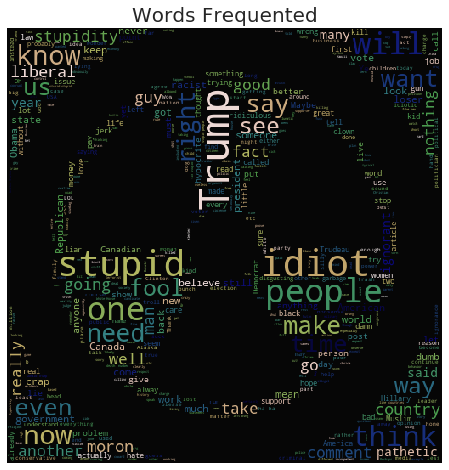

In [27]:
toxicwordcloud(picture = "../input/imagesforkernal/toxic-sign.png")

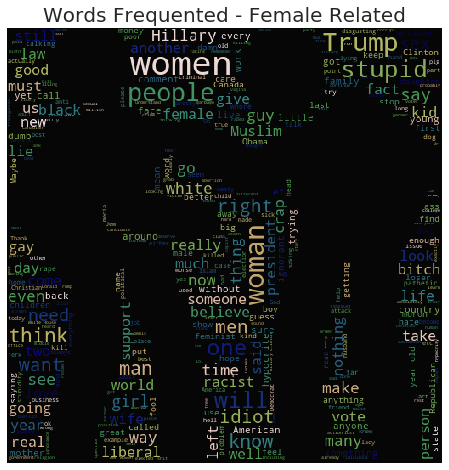

In [28]:
toxicwordcloud(subset = train[(train['female'] >0)&(train['target']>0.8)],title = "Words Frequented - Female Related", picture = "../input/imagesforkernal/anger.png")

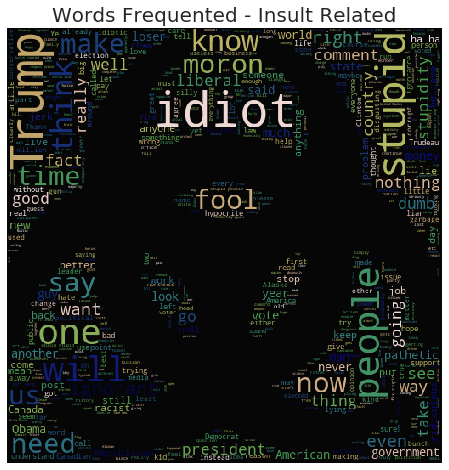

In [29]:
toxicwordcloud(subset = train[(train['insult'] >0.8)&(train['target']>0.8)],title = "Words Frequented - Insult Related", picture = "../input/imagesforkernal/biohazard-symbol.png")

Some simple clasic text precessing and generating the new dataset

In [30]:
import operator 
import re
import gensim

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning:

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress



In [31]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

In [32]:
# Due to the memory limit, here we only are using glove, while if you have a better machine, you can also load crawl and other embeddings

df = pd.concat([train.iloc[:, [0,2]] ,test.iloc[:, :2]])
glove = '../input/glove840b300dtxt/glove.840B.300d.txt'
# crawl =  '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
    
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    if file == '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec':
        embeddings_index = gensim.models.KeyedVectors.load_word2vec_format(crawl)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [33]:
print("Extracting GloVe embedding")
embed_glove = load_embed(glove)
# print("Extracting Crawl embedding")
# embed_crawl = load_embed(crawl)

Extracting GloVe embedding


In [34]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

vocab = build_vocab(df['comment_text'])

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [35]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
# print("Crawl : ")
# oov_crawl = check_coverage(vocab, embed_crawl)

Glove : 
Found embeddings for 15.52% of vocab
Found embeddings for  89.61% of all text


In [36]:
df['lowered_comment'] = df['comment_text'].apply(lambda x: x.lower())
vocab_low = build_vocab(df['lowered_comment'])
print("Glove : ")
oov_glove = check_coverage(vocab_low, embed_glove)
# print("Crawl : ")
# oov_crawl = check_coverage(vocab_low, embed_crawl)

Glove : 
Found embeddings for 11.77% of vocab
Found embeddings for  89.33% of all text


In [37]:
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")
    
print("Glove : ")
add_lower(embed_glove, vocab)
# oov_glove = check_coverage(vocab_low, embed_glove)
# print("Crawl : ")
# add_lower(embed_crawl, vocab)
# oov_crawl = check_coverage(vocab_low, embed_crawl)

# Check Result
oov_glove[:10]

Glove : 
Added 25061 words to embedding


[("i'm", 87786),
 ("isn't", 46659),
 ("he's", 38057),
 ("won't", 31829),
 ('yes,', 29407),
 ("i've", 28451),
 ("there's", 26789),
 ('"the', 26467),
 ("trump's", 25755),
 ("let's", 24190)]

The following contraction_mapping is borrowed from @Aditya Soni. Credit goes to https://www.kaggle.com/adityaecdrid/public-version-text-cleaning-vocab-65

In [38]:
contraction_mapping = {
    "Trump's" : 'trump is',"'cause": 'because',',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have',
    'can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop',
    }

In [39]:
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

print("- Known Contractions -")
print("   Glove :")
print(known_contractions(embed_glove))
# print("   Crawl :")
# print(known_contractions(embed_crawl))

- Known Contractions -
   Glove :
["'cause", "can't", "didn't", "doesn't", "don't", "i'd", "i'll", "i'm", "i've", "It's", "it's", "ma'am", "that's", "you'll", "you're", 'you.i', "c'mon", "d'int"]


In [40]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

df['treated_comment'] = df['lowered_comment'].apply(lambda x: clean_contractions(x, contraction_mapping))

vocab = build_vocab(df['treated_comment'])

print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
# print("Crawl : ")
# oov_paragram = check_coverage(vocab, embed_crawl)

Glove : 
Found embeddings for 13.51% of vocab
Found embeddings for  90.40% of all text


In [41]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

print("Glove :")
print(unknown_punct(embed_glove, punct))
# print("Crawl :")
# print(unknown_punct(embed_crawl, punct))

Glove :
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 


In [42]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    for p in punct:
        text = text.replace(p, f' {p} ')
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    return text

df['treated_comment'] = df['treated_comment'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
vocab = build_vocab(df['treated_comment'])

print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
# print("Crawl : ")
# oov_paragram = check_coverage(vocab, embed_crawl)

Glove : 
Found embeddings for 54.21% of vocab
Found embeddings for  99.73% of all text


In [43]:
oov_glove[:10]

[('brexit', 2043),
 ('theglobeandmail', 1423),
 ('québec', 1365),
 ('drumpf', 1294),
 ('deplorables', 1274),
 ('trumpcare', 869),
 ('sb91', 841),
 ('theguardian', 795),
 ('klastri', 754),
 ('trumpism', 599)]

In [44]:
mispell_dict = {'SB91':'senate bill','tRump':'trump','utmterm':'utm term','FakeNews':'fake news','Gʀᴇat':'great','ʙᴏᴛtoᴍ':'bottom','washingtontimes':'washington times','garycrum':'gary crum','htmlutmterm':'html utm term','RangerMC':'car','TFWs':'tuition fee waiver','SJWs':'social justice warrior','Koncerned':'concerned','Vinis':'vinys','Yᴏᴜ':'you','Trumpsters':'trump','Trumpian':'trump','bigly':'big league','Trumpism':'trump','Yoyou':'you','Auwe':'wonder','Drumpf':'trump','utmterm':'utm term','Brexit':'british exit','utilitas':'utilities','ᴀ':'a', '😉':'wink','😂':'joy','😀':'stuck out tongue', 'theguardian':'the guardian','deplorables':'deplorable', 'theglobeandmail':'the globe and mail', 'justiciaries': 'justiciary','creditdation': 'Accreditation','doctrne':'doctrine','fentayal': 'fentanyl','designation-': 'designation','CONartist' : 'con-artist','Mutilitated' : 'Mutilated','Obumblers': 'bumblers','negotiatiations': 'negotiations','dood-': 'dood','irakis' : 'iraki','cooerate': 'cooperate','COx':'cox','racistcomments':'racist comments','envirnmetalists': 'environmentalists',}

In [45]:
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

df['treated_comment'] = df['treated_comment'].apply(lambda x: correct_spelling(x, mispell_dict))

vocab = build_vocab(df['treated_comment'])

print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
# print("Crawl : ")
# oov_paragram = check_coverage(vocab, embed_crawl)

Glove : 
Found embeddings for 54.21% of vocab
Found embeddings for  99.73% of all text


In [46]:
train['comment_text'] = df['treated_comment'][:1804874]
test['comment_text'] = df['treated_comment'][1804874:]

In [47]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [48]:
print('-' * 80)
print('train')
train = reduce_mem_usage(train)

print('-' * 80)
print('test')
test = reduce_mem_usage(test)

--------------------------------------------------------------------------------
train
Memory usage of dataframe is 619.65 MB
Memory usage after optimization is: 350.86 MB
Decreased by 43.4%
--------------------------------------------------------------------------------
test
Memory usage of dataframe is 1.49 MB
Memory usage after optimization is: 3.98 MB
Decreased by -168.1%


Test the Difficulty of this Classification Tasks.
(Borrowed from

Kernel: https://www.kaggle.com/shujian/test-the-difficulty-of-this-classification-tasks

Paper: https://arxiv.org/abs/1811.01910

Code: https://github.com/Wluper/edm)

In [49]:
!pip install edm

  Stored in directory: /tmp/.cache/pip/wheels/f5/9b/f6/778ef88e921a1c1ef7b9d04d1af501a7014d89e941c3301c56
Successfully built edm
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [50]:
df = train.sample(frac=0.003)
sents = df["comment_text"].values
labels = df["target"].values
from edm import report
print(report.get_difficulty_report(sents, labels))

----> Building bag of words representations...
[-------------------------------] : 5414 of 5415, 100.0% : Est. 0.0 mins Remaining
----> Done.
----> Getting difficulty metrics...
----> Done.
----> Getting generic statistics...
----> Done.


Dataset Size                 5415                 -
Vocab Size                   20377                -
Number of Classes            210                  -
Mean Items Per Class         25.785714285714285   -
Min. Items in a Class        1                    EXTREMELY LOW
Average Sentence Length      318.3405355493998    -
Distinct Words : Total Words 0.07180284082300002  GOOD
Class Imbalance              1.8031130457723257   VERY HIGH
Class Diversity              1.467011623272505    SOMEWHAT HIGH
Max. Hellinger Similarity    0.9253487508471283   VERY HIGH
Mutual Information           0.038380264515979534 GOOD
Difficulty                   4.305656525230939    HIGH





In [51]:
train.to_pickle("train.pkl")
test.to_pickle("test.pkl")
train.to_csv('train_cleaned.csv', index=None)
test.to_csv('test_cleaned.csv', index=None)

**To be continued...**

![](https://habrastorage.org/webt/mh/4h/nr/mh4hnrif7tzbmycmjpiduozssa4.png)